## Part 3

$\mu = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}(1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right) = 5 \log \left( \frac{c/H_0} {10 {\rm pc}}\right) + 5\log \left((1+z)\int_0^z \frac{dz'}{\sqrt{\Omega_m (1+z^3)+\Omega_\Lambda}} \right)$

- Assuming a flat Universe, we have a parametric non-linear model for $\mu$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$
- It's a very non-linear model. **Fit it to the data, however you want to do it, using tecniques we've seen throughout the course.**
- What are the measured value of $H_0$ and $\Omega_m$? What are theyre errors? Are they correlated? 
- How would a model without dark energy (i.e. $\Omega_m = 1$) perform? Do these data contain evidence of dark energy?


Flat Universe: $$\Omega_{\Lambda}  = 1 - \Omega_m $$

$$ \mu = 5 log\left( \frac{c/H_0}{10\text{pc}}(1+z)\int_0^{z} 
\frac{dz'}{\sqrt{\Omega_m z'^3 +  1}}\right) $$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
path = r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks"
sys.path.append(path)
from Utilities import plot_settings

In [4]:
data = np.genfromtxt(r'C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\Data\mu_z.txt', delimiter=' ')

In [5]:
z_sample  = data[:, 0]
mu_sample = data[:, 1]
dmu       = data[:, 2]

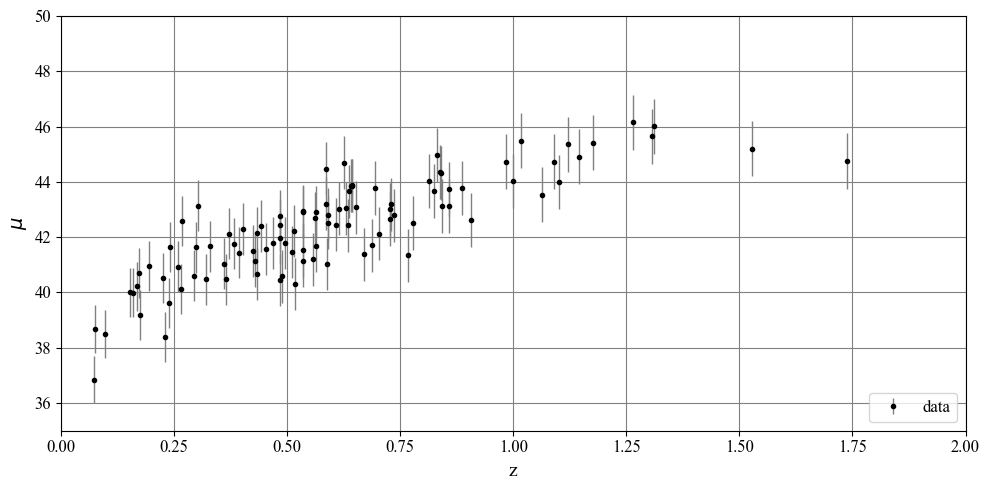

In [6]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

**Fit it to the data, however you want to do it, using tecniques we've seen throughout the course.**\

# MCMC

In [7]:
from scipy.integrate import quad
from scipy.special import gammaln
import numpy as np

c = 299792.458  # speed of light in km/s
nu = 2  # Student-t degrees of freedom

# General integrand with Omega_m and Omega_Lambda
def integrand(zp, omega_m, omega_lambda):
    omega_k = 1.0 - omega_m - omega_lambda
    return 1.0 / np.sqrt(omega_m * (1 + zp)**3 + omega_lambda + omega_k * (1 + zp)**2)

# General luminosity distance (non-flat)
def mu_theoretical(z, H0, omega_m, omega_lambda):
    mu = []
    omega_k = 1.0 - omega_m - omega_lambda
    for zi in z:
        integral, _ = quad(integrand, 0, zi, args=(omega_m, omega_lambda))
        dc = (c / H0) * integral

        if omega_k > 0:
            sqrt_ok = np.sqrt(omega_k)
            dL = (1 + zi) * (c / H0) / sqrt_ok * np.sinh(sqrt_ok * integral)
        elif omega_k < 0:
            sqrt_ok = np.sqrt(-omega_k)
            dL = (1 + zi) * (c / H0) / sqrt_ok * np.sin(sqrt_ok * integral)
        else:  # Flat universe
            dL = (1 + zi) * dc

        mu_i = 5 * np.log10(dL * 1e6 / 10)  # Mpc → pc, then modulus
        mu.append(mu_i)
    return np.array(mu)

# Log-likelihood with Student's t-distribution
def log_likelihood_t(theta):
    H0, omega_m, omega_lambda = theta
    if H0 <= 0 or not (0 <= omega_m <= 1) or not (0 <= omega_lambda <= 1) or omega_m + omega_lambda > 2:
        return -np.inf

    mu_model = mu_theoretical(z_sample, H0, omega_m, omega_lambda)
    residuals = (mu_sample - mu_model) / dmu

    part1 = gammaln((nu + 1) / 2) - gammaln(nu / 2)
    part2 = -0.5 * np.log(nu * np.pi)
    part3 = -((nu + 1) / 2) * np.log(1 + (residuals**2) / nu)

    return np.sum(part1 + part2 + part3)

# Gaussian log-likelihood (optional)
def log_likelihood(theta):
    H0, omega_m, omega_lambda = theta
    if H0 <= 0 or not (0 <= omega_m <= 1) or not (0 <= omega_lambda <= 1) or omega_m + omega_lambda > 2:
        return -np.inf
    mu_model = mu_theoretical(z_sample, H0, omega_m, omega_lambda)
    return -0.5 * np.sum(((mu_sample - mu_model) / dmu)**2 + np.log(2 * np.pi * dmu**2))

# Uniform prior over reasonable cosmological ranges
def log_prior(theta):
    H0, omega_m, omega_lambda = theta
    if 50 < H0 < 100 and 0 <= omega_m <= 1 and 0 <= omega_lambda <= 1:
        return 0.0
    return -np.inf

# Posterior
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_t(theta)

In [8]:
ndim = 3
nwalkers = 20
nsteps = int(1e4)

In [9]:
initial = np.array([70, 0.3, 0.7])  + 1e-2 * np.random.randn(nwalkers, ndim)
p0 = initial + 1e-2 * np.random.randn(nwalkers, ndim)

In [10]:
import emcee

In [11]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

In [13]:
sampler.run_mcmc(p0, nsteps, progress=True)

100%|██████████| 10000/10000 [20:24<00:00,  8.17it/s]


State([[6.60486689e+01 7.10806557e-01 4.87678140e-01]
 [5.89588139e+01 9.48045567e-01 3.47465106e-01]
 [6.09250442e+01 9.65631914e-01 2.86381009e-01]
 [6.22847971e+01 8.11984628e-01 2.63072746e-01]
 [6.08484493e+01 5.20761849e-01 1.66175744e-01]
 [7.78102872e+01 1.05759822e-01 7.16163068e-01]
 [6.77931131e+01 1.33776323e-01 3.89201930e-01]
 [6.45248557e+01 4.59295364e-01 4.64298214e-01]
 [6.50245211e+01 5.73605655e-01 3.81979340e-01]
 [6.42102794e+01 4.74601627e-03 2.58187214e-01]
 [5.98200627e+01 6.79382278e-01 2.10303247e-01]
 [6.86269294e+01 1.27831435e-01 7.68626090e-01]
 [6.12952734e+01 6.81309527e-01 8.04597123e-01]
 [6.39162241e+01 8.96061147e-01 7.93330248e-01]
 [7.27994429e+01 1.00051778e-01 7.81749244e-01]
 [6.28070898e+01 7.59579190e-01 8.67758739e-01]
 [6.76232530e+01 3.70314203e-01 9.49003645e-02]
 [5.80754480e+01 7.70120456e-01 5.17753203e-01]
 [7.17897036e+01 7.73037703e-02 4.72709402e-01]
 [6.78500023e+01 1.79203918e-01 6.40266698e-01]], log_prob=[-152.7204462  -152.125

Check acceptance rate

In [14]:
print("Acceptance fraction per walker:")
print(sampler.acceptance_fraction)
print("Mean acceptance rate: {:.3f}".format(np.mean(sampler.acceptance_fraction)))

Acceptance fraction per walker:
[0.56465903 0.55420607 0.55749129 0.55390742 0.56017919 0.55968143
 0.54743654 0.54484818 0.53927327 0.55848681 0.54464908 0.55231458
 0.54753609 0.5483325  0.56396217 0.54823295 0.55350921 0.56236934
 0.55251369 0.55271279]
Mean acceptance rate: 0.553


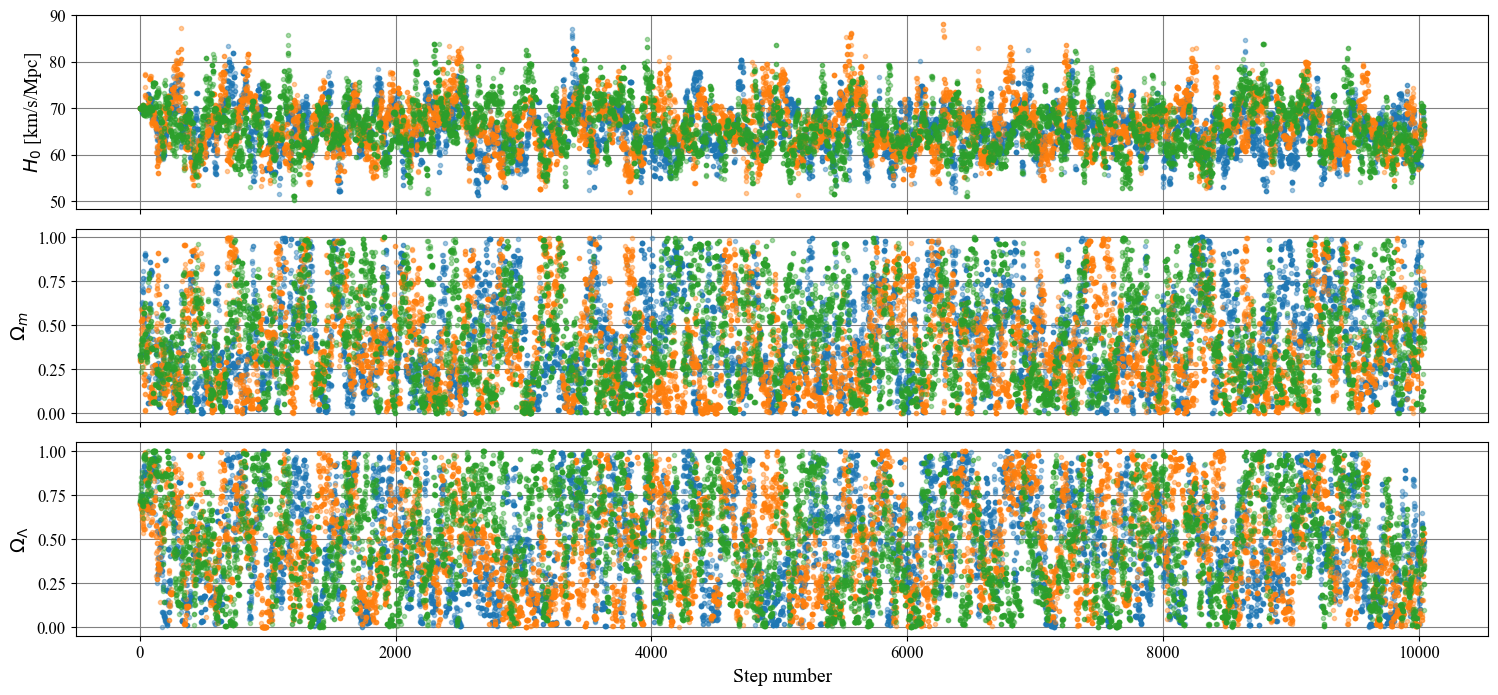

In [15]:
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)
labels = [r"$H_0$ [km/s/Mpc]", r"$\Omega_m$", r"$\Omega_{\Lambda}$"]

# Assuming sampler.get_chain() shape is (n_steps, n_walkers, ndim)
chain = sampler.get_chain()
np.save("chain.npy", chain)
for i in range(ndim):
    ax = axes[i]
    # Plot every 8th walker
    for walker in range(0, chain.shape[1], 8):
        ax.plot(chain[:, walker, i], '.', alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)

axes[-1].set_xlabel("Step number")
plt.tight_layout()

In [16]:
tau = int(max(sampler.get_autocorr_time()))
flat_samples = sampler.get_chain(discard=100, thin=tau, flat=True)

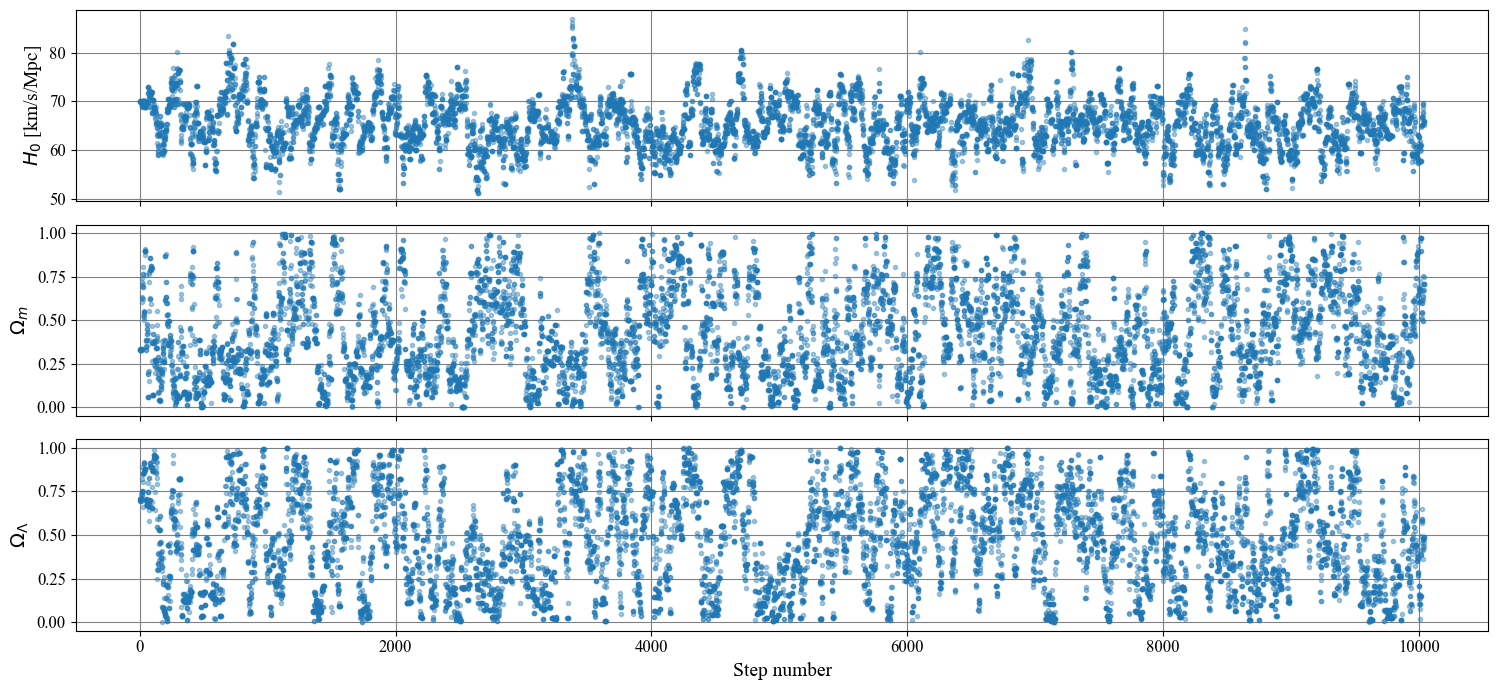

In [17]:
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)
labels = [r"$H_0$ [km/s/Mpc]", r"$\Omega_m$", r"$\Omega_{\Lambda}$"]

for i in range(ndim):
    ax = axes[i]
    # Plot every 8th walker
    for walker in range(0, flat_samples.shape[1], 8):
        ax.plot(chain[:, walker, i], '.', alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)

axes[-1].set_xlabel("Step number")
plt.tight_layout()


In [18]:
import corner

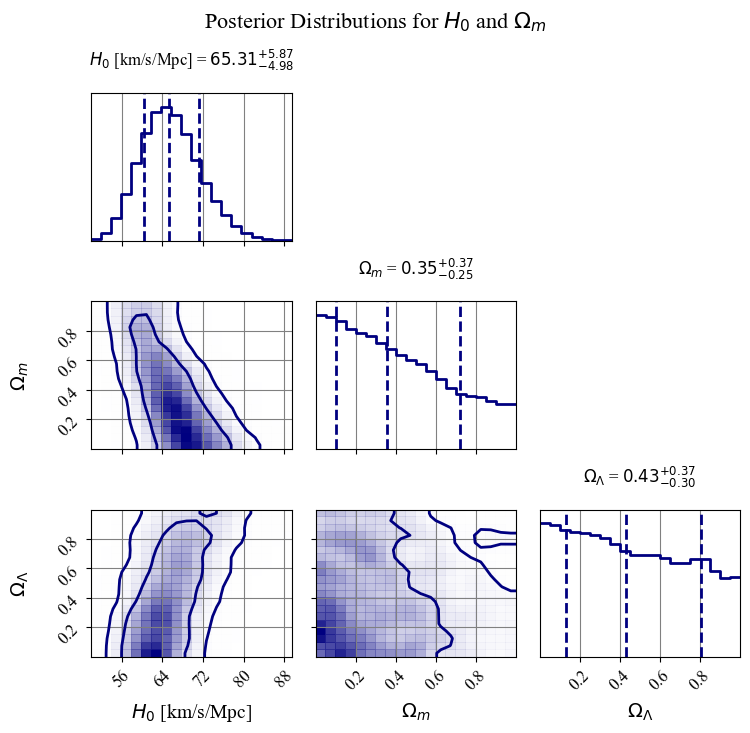

In [19]:
fig = corner.corner(
    flat_samples,
    labels=labels,
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    quantiles=[0.16, 0.5, 0.84],
    levels=(0.68, 0.95),
    plot_contours=True,
    plot_density=True,
    plot_datapoints=False,  # cleaner look
    color="navy",
    smooth=1.0,  # smoothing for density
    smooth1d=1.0,
    figsize=(6, 6),
)

fig.suptitle("Posterior Distributions for $H_0$ and $\Omega_m$", fontsize=16)
plt.tight_layout()
plt.show()


In [20]:
import numpy as np

# Assuming `flat_samples` is of shape (n_samples, 2) → [H0, Omega_m]
param_names = ['H0', 'Omega_matter', 'Omega_lambda']
results = []

for i in range(flat_samples.shape[1]):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    results.append((mcmc[1], q[0], q[1]))
    print(f"{param_names[i]} = {mcmc[1]:.2f} (+{q[1]:.2f}, -{q[0]:.2f})")


H0 = 65.31 (+5.87, -4.98)
Omega_matter = 0.35 (+0.37, -0.25)
Omega_lambda = 0.43 (+0.37, -0.30)


In [21]:
corr_matrix = np.corrcoef(flat_samples.T)

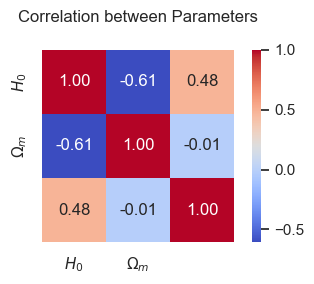

In [22]:
import seaborn as sns

sns.set(style="white")
fig, ax = plt.subplots(figsize=(4, 3))

sns.heatmap(corr_matrix, annot=True, fmt=".2f",
            xticklabels=[r"$H_0$", r"$\Omega_m$"],
            yticklabels=[r"$H_0$", r"$\Omega_m$"],
            cmap="coolwarm", cbar=True, square=True, ax=ax)

plt.title("Correlation between Parameters")
plt.tight_layout()

Comments:
- to fit the same observed luminosity distances, increasing $H_0$ can be compensated by reducing $\Omega_m$. They're degenerate in the distance-redshift relation.
-  increasing both $H_0$ and $\Omega_{\Lambda}$ leads to more cosmic acceleration, helping to maintain the same luminosity distance curves.
- $\Omega_{\Lambda}$ and $\Omega_m$ seem to be independent.

In [23]:
z_fit = np.linspace(min(z_sample), max(z_sample), 200)

In [24]:
mu_chain = []
for h0, omega_m, omega_lambda in flat_samples[np.random.choice(len(flat_samples), 500, replace=False)]:
    mu_chain.append(mu_theoretical(z_fit, h0, omega_m, omega_lambda))
mu_chain = np.array(mu_chain)

In [25]:
mu_median = np.median(mu_chain, axis=0)
mu_lower = np.percentile(mu_chain, 16, axis=0)
mu_upper = np.percentile(mu_chain, 84, axis=0)

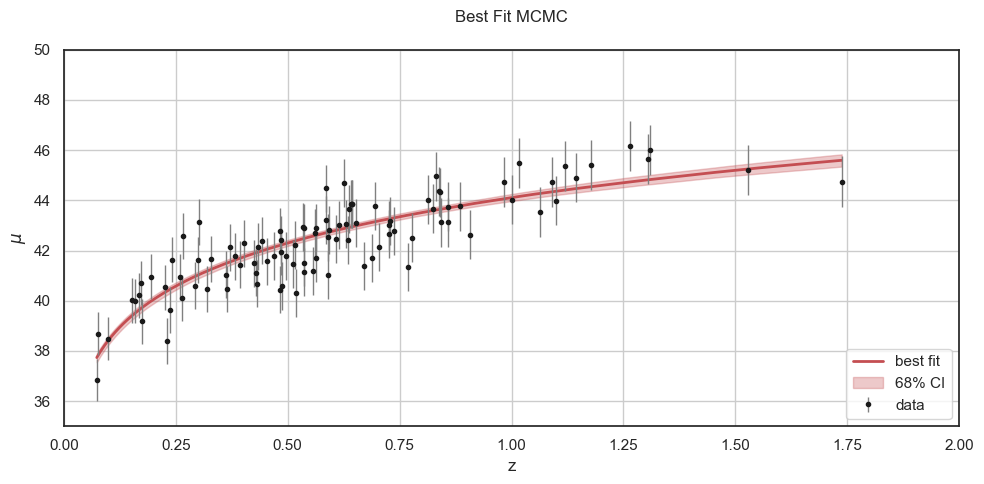

In [26]:
plt.plot(z_fit, mu_median, lw=2, color='r', label='best fit')
plt.fill_between(z_fit, mu_lower, mu_upper, color='r', alpha=0.3, label='68% CI')
plt.title('Best Fit MCMC')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.grid(True)


In [27]:
omega_m = flat_samples[:, 1]
omega_lambda = flat_samples[:, 2]

## Model Selection : Savage-Dickey Density Ratio

$B_{21} = \frac{p(\Omega_{\Lambda}=1\Omega_m|M_2)}{p(\Omega_{\Lambda}=1\Omega_m|D,M_2)}$

In [32]:
from scipy.stats import gaussian_kde
import numpy as np

# 2D KDE over (Omega_m, Omega_Lambda)
kde_post = gaussian_kde(np.vstack([omega_m, omega_lambda]))

# Evaluate the KDE along the flat line: Omega_Lambda = 1 - Omega_m
kde_values_post = kde_post.evaluate(np.vstack([omega_m, 1 - omega_m]))

posterior_density = np.mean(kde_values_post)
print(f'Posterior density at ΩΛ = 1 - Ωm: {posterior_density:.2}')

Posterior density at ΩΛ = 1 - Ωm: 0.96


In [33]:
# Simulate prior samples (uniform over [0,1])
n_prior = 10000
prior_omega_m = np.random.uniform(0, 1, n_prior)
prior_omega_lambda = np.random.uniform(0, 1, n_prior)

# KDE of prior samples
kde_prior = gaussian_kde(np.vstack([prior_omega_m, prior_omega_lambda]))

# Evaluate prior density along Omega_Lambda = 1 - Omega_m
kde_values_prior = kde_prior.evaluate(np.vstack([prior_omega_m, 1 - prior_omega_m]))

prior_density = np.mean(kde_values_prior)
print("Prior density at ΩΛ = 1 - Ωm:", prior_density)

Prior density at ΩΛ = 1 - Ωm: 0.9092372573069107


In [34]:
bayes_factor = posterior_density / prior_density
print(f"Bayes factor B₀₁ (in favor of flat universe): {bayes_factor:.3f}")

Bayes factor B₀₁ (in favor of flat universe): 1.057


Evidence supporting a flat universe model (e.g. $\Omega_{\Lambda} = 1 - \Omega_m$) according to Jeffry's scale is **barely worth mentioning**